In [13]:
# import keras
import fastai
from fastai.vision import *
from fastai.metrics import fbeta, Precision, Recall, accuracy_thresh

import pandas as pd
import numpy as np

import os
import shutil
from pathlib import Path
import tarfile

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
path_raw_data = Path('../../data/kaggle/sample/')
files = os.listdir(path_raw_data)
files

['images', 'sample.zip', 'sample_labels.csv']

In [3]:
path_data = path_raw_data/'images'

In [4]:
# verify_images(path_data, n_channels=1)

In [5]:
img_files = os.listdir(path_data)
img_files[:5], len(img_files)

(['00025360_008.png',
  '00012116_001.png',
  '00016291_006.png',
  '00022893_000.png',
  '00017136_018.png'],
 5608)

In [6]:
df_labels = pd.read_csv(path_raw_data/"sample_labels.csv")
# print(df_labels.head(), df_labels.shape)
df_labels = df_labels.loc[df_labels['Image Index'].isin(img_files)]
# df_labels = df_labels.iloc[:200]
df_labels.shape

(5606, 11)

In [7]:
# df_labels = df_labels[df_labels['Finding Labels'] != 'No Finding']

df_labels.loc[df_labels['Finding Labels'] == 'No Finding', 'Finding Labels'] = ''

## to get only one of each class
# df_labels = df_labels.groupby('Finding Labels').apply(lambda x: x.sample(1)).reset_index(drop=True)

df_labels

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000
2,00000017_001.png,,1,17,077Y,M,AP,2500,2048,0.168000,0.168000
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168000,0.168000
6,00000042_002.png,,2,42,071Y,M,AP,3056,2544,0.139000,0.139000
7,00000057_001.png,,1,57,071Y,M,AP,3056,2544,0.139000,0.139000
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143000,0.143000
9,00000061_019.png,,19,61,077Y,M,AP,3056,2544,0.139000,0.139000


In [8]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.02)

basic_block = (ImageList
                .from_df(df_labels,
                         path=path_data)
                .split_by_rand_pct(0.2)
                .label_from_df(label_delim='|'))

db_xrays = (basic_block
            .transform(tfms, 
                       size=64) 
            .databunch(bs=32))

db_xrays.normalize(imagenet_stats)

db_xrays.export()

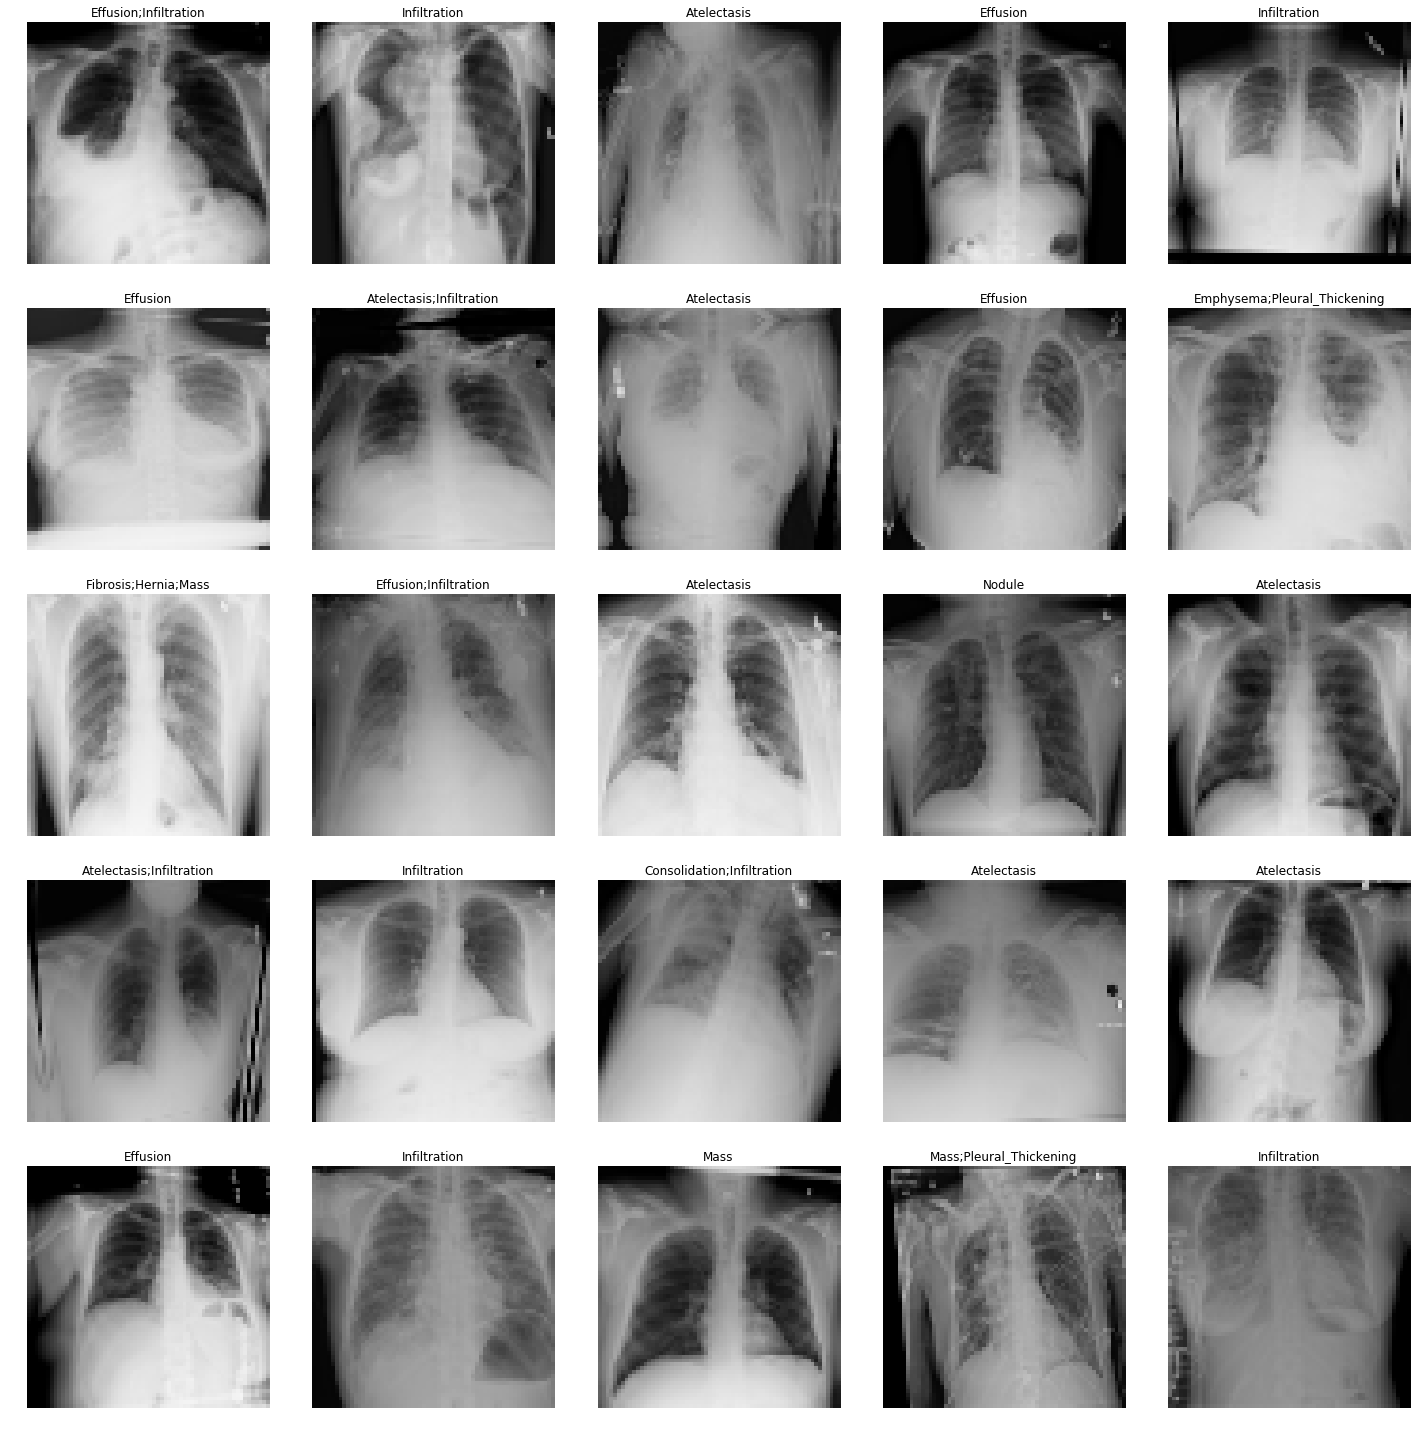

In [123]:
db_xrays.show_batch()

In [10]:
from functools import partial

accuracy_20 = partial(accuracy_thresh, thresh=0.2)

model = cnn_learner(data=db_xrays, 
                   base_arch=models.densenet121,
                   metrics=[fbeta, accuracy_20])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/gurudev/.torch/models/densenet121-a639ec97.pth
32342954it [00:08, 3811468.26it/s]


In [12]:
# model.load('./brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

In [130]:
model.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 32, 32]      9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 32, 32]      128        True      
______________________________________________________________________
ReLU                 [1, 64, 32, 32]      0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 16, 16]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 16, 16]      4,096      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 16, 16]      128        True      
______________________________________________________________________
Conv2d               [1, 64, 16, 16]      36,864     False     
______________________________________________________________

In [202]:
model.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [184]:
model.data.c, model.data.classes

(14,
 ['Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Effusion',
  'Emphysema',
  'Fibrosis',
  'Hernia',
  'Infiltration',
  'Mass',
  'Nodule',
  'Pleural_Thickening',
  'Pneumonia',
  'Pneumothorax'])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


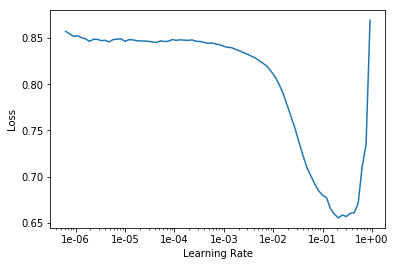

In [192]:
model.lr_find()
model.recorder.plot()

In [200]:
model.fit_one_cycle(cyc_len=5, max_lr=7e-2)

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.230400,0.191411,0.069817,0.914107,00:36
1,0.228884,0.194736,0.126654,0.909392,00:37
2,0.209271,0.191874,0.021126,0.937683,00:36
3,0.187877,4.346437,0.047851,0.929336,00:36
4,0.179836,0.172173,0.061855,0.941761,00:36


In [201]:
model.save('stage1')

In [203]:
model.load('stage1')
model.unfreeze()
model.freeze_to(0)
# model.freeze()

In [204]:
model.data = (basic_block
            .transform(tfms, 
                       size=128) 
            .databunch(bs=32))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


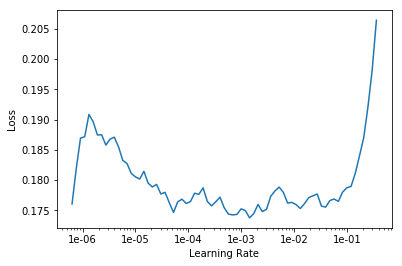

In [205]:
model.lr_find()
model.recorder.plot()

In [206]:
model.fit_one_cycle(cyc_len=6, max_lr=slice(1e-5))

epoch,train_loss,valid_loss,fbeta,accuracy_thresh,time
0,0.178613,0.174714,0.061987,0.940551,00:40
1,0.178349,0.173872,0.064776,0.937174,00:41
2,0.176079,0.173641,0.059650,0.938384,00:39
3,0.180584,0.173240,0.062761,0.938257,00:40
4,0.179638,0.173295,0.057508,0.940614,00:41
5,0.177173,0.173037,0.062464,0.938575,00:40


In [207]:
model.save('stage2')

In [211]:
# x, y = next(iter(model.data.train_dl))

LabelList (4485 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Emphysema;Infiltration;Pleural_Thickening;Pneumothorax,Cardiomegaly;Emphysema,,Atelectasis,Cardiomegaly;Edema;Effusion
Path: ../../data/kaggle/sample/images

In [191]:
# y.sum(dim=1)

tensor([0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 2., 2., 4., 2., 2., 0., 1.,
        1., 1., 2., 2., 1., 0., 2., 1., 1., 1., 0., 1., 0., 1.],
       device='cuda:0')

In [217]:
# dt = vision.open_image(path_data/'00030635_002.png')
for i in range(20):
    print('\n')
    dt = model.data.train_ds[i]
    print(dt[1])
    predict_class, predict_idx, predict_values = model.predict(dt[0])
    print(predict_values, np.array(model.data.classes)[np.array(predict_values.tolist()) > 0.1])



Emphysema;Infiltration;Pleural_Thickening;Pneumothorax
tensor([0.1078, 0.0414, 0.0825, 0.0387, 0.2102, 0.0300, 0.0126, 0.0019, 0.2325,
        0.1022, 0.0943, 0.0620, 0.0195, 0.1119]) ['Atelectasis' 'Effusion' 'Infiltration' 'Mass' 'Pneumothorax']


Cardiomegaly;Emphysema
tensor([0.0794, 0.0157, 0.0171, 0.0066, 0.0474, 0.0156, 0.0100, 0.0009, 0.1362,
        0.0346, 0.0535, 0.0164, 0.0041, 0.0239]) ['Infiltration']



tensor([0.1252, 0.0283, 0.0401, 0.0179, 0.0867, 0.0109, 0.0056, 0.0010, 0.1638,
        0.0401, 0.0490, 0.0142, 0.0067, 0.0322]) ['Atelectasis' 'Infiltration']


Atelectasis
tensor([0.0679, 0.0195, 0.0263, 0.0064, 0.0868, 0.0256, 0.0304, 0.0023, 0.1110,
        0.0863, 0.0595, 0.0393, 0.0068, 0.0776]) ['Infiltration']


Cardiomegaly;Edema;Effusion
tensor([0.1537, 0.0365, 0.0796, 0.0440, 0.1545, 0.0149, 0.0049, 0.0013, 0.2316,
        0.0570, 0.0542, 0.0207, 0.0133, 0.0464]) ['Atelectasis' 'Effusion' 'Infiltration']


Consolidation;Mass
tensor([0.0619, 0.0117, 0.0086, 0.

In [144]:
preds,y,losses = model.get_preds(with_loss=True)

In [109]:
preds = preds.float()
y = y.float()
losses = losses.float()

In [146]:
# interp = ClassificationInterpretation(model, preds, y, losses)
# interp.most_confused()

tensor([0.1666, 0.0476, 0.0914, 0.0365, 0.2287, 0.0535, 0.0245, 0.0028, 0.3991,
        0.1073, 0.1171, 0.0640, 0.0156, 0.1249])


MultiCategory 